# Solution for the titanic problem

Author: Bruno Martins

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

Read the dataset

In [87]:
train_df = pd.read_csv('datasets/train.csv')

Analyze some information about the columns

In [88]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Now, visualize the data for each of the classes

Information about the deceased

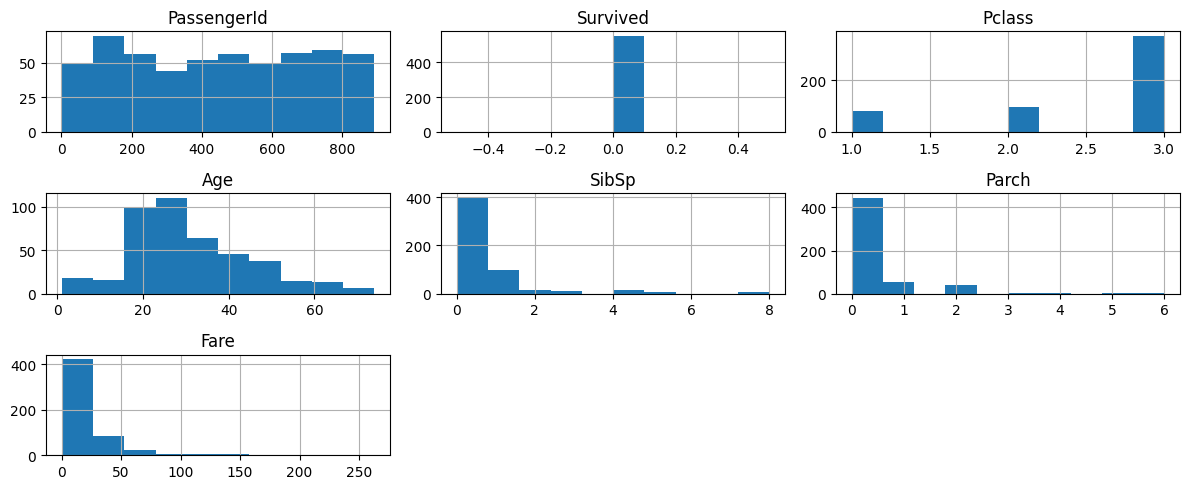

In [89]:
train_df[train_df['Survived'] == 0].hist(figsize=(12,5))
plt.tight_layout()

Information about the survivors

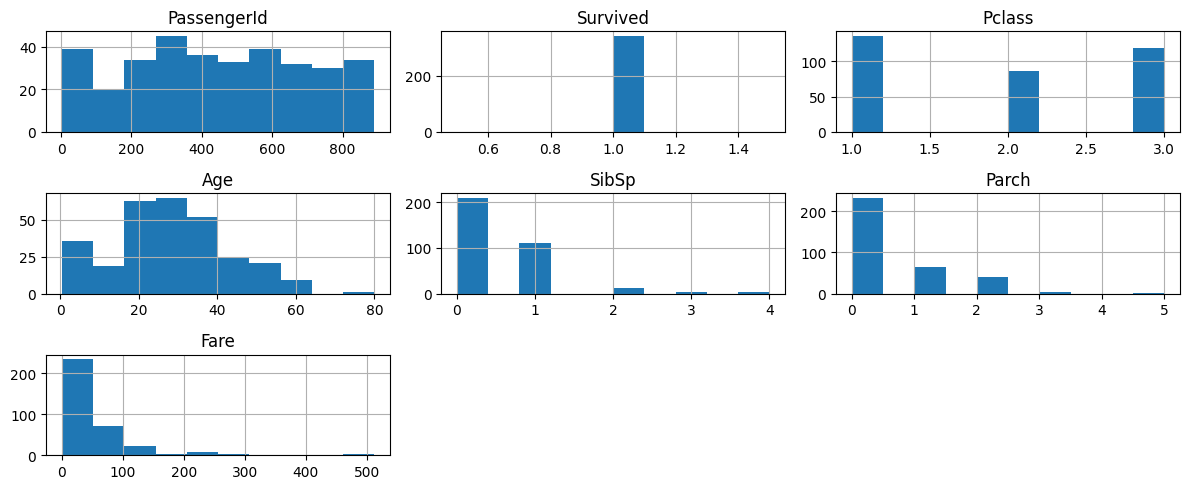

In [90]:
train_df[train_df['Survived'] == 1].hist(figsize=(12,5))
plt.tight_layout()

Plot the correlation matrix for the columns 

In [91]:
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Drop some irrelavant features

In [92]:
train_df = train_df.drop('Name', axis=1)
train_df = train_df.drop('PassengerId', axis=1)
train_df = train_df.drop('Ticket', axis=1)
train_df = train_df.drop('Cabin', axis=1)

Import the classes and methods from sklearn to apply the machine learning

In [93]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

Read the test dataset

In [94]:
test_df = pd.read_csv('./datasets/test.csv')

In [95]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Again, drop irrelevant features

In [96]:
passenger_id = test_df['PassengerId'].values
test_df = test_df.drop('Name', axis=1)
test_df = test_df.drop('PassengerId', axis=1)
test_df = test_df.drop('Ticket', axis=1)
test_df = test_df.drop('Cabin', axis=1)

Separate the feature matrix from the label vector

In [97]:
y = train_df.iloc[:, 0]
X = train_df.iloc[:, 1:]
X_test = test_df

Now, let's build some pipelines to deal with the data.

In [100]:
# instantiates the scaler to be used. As described in the lecture, 
# MinMaxScaler is preferable over standardization when dealing with algorithms
# sensible to distance. In this case, we're planning to use KNN as a classifier
scaler = MinMaxScaler()
# imputers are needed to deal with missing values. In this case, we are replacing 
# by the median given the skewness of this feature's distribution
fare_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# When it comes to categorical values, replacing missing values by the most 
# frequent one might be a good idea.
embarked_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# In the case of age, we're replacing by the mean
age_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# One hot encoder is needed to work with categorical features.
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Now, we instatiate the classifier.
classifier = KNeighborsClassifier(n_neighbors=3)
# There are actually two categorical columns, but we're avoiding
# redudancy as it'll be seen later
categorical_columns = ['Sex']
# Again, there are more numerical columns
numerical_columns = ['Pclass', 'SibSp', 'Parch'] 

# This pipelines deal with missing values in the age column
# and also performs normalization. There's some 
# redundancy in the code because columnTransformer performs operations
# in parallel
age_pipe = Pipeline([
    ('fillmean', age_imputer),
    ('normalization', scaler),
])
# builds the pipe for the embarked. The encoder in the end means 
# it's a categorical value which should be encoded after dealing with nans
embarked_pipe = Pipeline([
    ('filltop', embarked_imputer),
    ('encoder', encoder),
])
# pipe for fare.
fare_pipe = Pipeline([
    ('fillmedian', fare_imputer),
    ('normalization', scaler)
])
# applies operations in parallel to the columns in the third value of each tuple
ct = ColumnTransformer([
    ('age', age_pipe, ['Age']),
    ('embarked', embarked_pipe, ['Embarked']),
    ('fare', fare_pipe, ['Fare']),
    ('encoder', encoder, categorical_columns),
    ('normalization', scaler, numerical_columns)]
)
# performs columnTransformer and then feeds the data to the classifier
pipeline = Pipeline([('transformer', ct), ('classification', classifier)])

In [ ]:
# Cross validation is a good idea so we can evaluate the performance of our model
# before measuring the generalization error on the test set.
cross_val_results = cross_validate(pipeline, X, y, cv=10)

In [101]:
# Gets the mean of each iteration of the Kfold method
cross_val_results['test_score'].mean()

0.8036579275905119

In [102]:
# Fit the model with the training data
model = pipeline.fit(X, y)
# Make predictions on the test set
y_predict = model.predict(X_test)

Builds a DataFrame with the output

In [103]:
submission_data = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_predict})

Now, we save the result for later submission on kaggle

In [ ]:
submission_data.to_csv('result.csv', index=False)